<a href="https://colab.research.google.com/github/AllanKDeveloper/transferlearning-python/blob/main/transferlearning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [14]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import requests
import zipfile
import io
import gdown
import os

# URLs for dataset
BASE_DIR = '/content/deepweeds'
IMAGES_URL = "https://drive.google.com/uc?export=download&id=1xnK3B6K6KekDI55vwJ0vnc2IGoDga9cj"
LABELS_URL = "https://raw.githubusercontent.com/AlexOlsen/DeepWeeds/master/labels/labels.csv"

# Configuration
INPUT_SIZE = (224, 224)
BATCH_SIZE = 32
EPOCHS = 5
NUM_CLASSES = 9  # 8 weed species + 1 negative class

# Create base directory in Colab
os.makedirs(BASE_DIR, exist_ok=True)

In [15]:
# Baixar imagens do Google Drive
!gdown 1xnK3B6K6KekDI55vwJ0vnc2IGoDga9cj --output {BASE_DIR}/images.zip

# Verificar se o arquivo ZIP é válido
zip_file = os.path.join(BASE_DIR, 'images.zip')
try:
    with zipfile.ZipFile(zip_file, 'r') as zip_ref:
        zip_ref.testzip()  # Testa se o arquivo ZIP está corrompido
    print("O arquivo ZIP é válido, extraindo imagens...")
    # Extrair as imagens
    with zipfile.ZipFile(zip_file, 'r') as zip_ref:
        zip_ref.extractall(BASE_DIR)
except zipfile.BadZipFile:
    print(f"O arquivo {zip_file} não é um ZIP válido ou está corrompido.")
    # Se o arquivo ZIP não for válido, baixe-o novamente ou busque outra fonte para o dataset
    raise

# Baixar os rótulos
print("Downloading labels...")
labels_df = pd.read_csv(LABELS_URL)

# Exibir as primeiras linhas do DataFrame para verificar as colunas
print(labels_df.head())

# Verificar se as colunas esperadas existem
if 'Filename' not in labels_df.columns or 'Label' not in labels_df.columns:
    raise KeyError("As colunas 'Filename' ou 'Label' não foram encontradas no DataFrame!")

# Adicionar caminho completo das imagens
labels_df['image_path'] = BASE_DIR + '/' + labels_df['Filename']

# Converter os rótulos para string, pois o class_mode='categorical' espera valores em string
labels_df['Label'] = labels_df['Label'].astype(str)

# Garantir que cada valor da coluna 'Label' seja uma lista de uma string (para compatibilidade com o flow_from_dataframe)
labels_df['Label'] = labels_df['Label'].apply(lambda x: [x])

Downloading...
From (original): https://drive.google.com/uc?id=1xnK3B6K6KekDI55vwJ0vnc2IGoDga9cj
From (redirected): https://drive.google.com/uc?id=1xnK3B6K6KekDI55vwJ0vnc2IGoDga9cj&confirm=t&uuid=4c1f7df5-0d25-4ff5-a967-6fdc43aaa92a
To: /content/deepweeds/images.zip
100% 492M/492M [00:03<00:00, 133MB/s] 
O arquivo ZIP é válido, extraindo imagens...
                Filename  Label       Species
0  20160928-140314-0.jpg      0  Chinee apple
1  20160928-140337-0.jpg      0  Chinee apple
2  20160928-140731-0.jpg      0  Chinee apple
3  20160928-140747-0.jpg      0  Chinee apple
4  20160928-141107-0.jpg      0  Chinee apple


In [16]:
# Dividir em treino e validação
train_df, val_df = train_test_split(labels_df, test_size=0.2, stratify=labels_df['Label'], random_state=42)

# Geradores de dados para treino e validação
train_datagen = ImageDataGenerator(
    rescale=1./255,  # Normaliza as imagens
    horizontal_flip=True,
    rotation_range=20,
    zoom_range=0.2
)
val_datagen = ImageDataGenerator(rescale=1./255)  # Normaliza as imagens de validação
val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_dataframe(
    train_df,
    x_col='image_path',
    y_col='Label',
    target_size=INPUT_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    seed=42
)

val_generator = val_datagen.flow_from_dataframe(
    val_df,
    x_col='image_path',
    y_col='Label',
    target_size=INPUT_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

Found 14007 validated image filenames belonging to 9 classes.
Found 3502 validated image filenames belonging to 9 classes.


In [17]:
# Construção do modelo com Transfer Learning
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  # Congela os pesos do modelo base

model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(NUM_CLASSES, activation='softmax')
])

# Compilação do modelo
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [18]:
early_stopping = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)

# Treinamento do modelo
history = model.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=val_generator,
    callbacks=[early_stopping]
)

Epoch 1/5


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


438/438 ━━━━━━━━━━━━━━━━━━━━ 1470s 3s/step - accuracy: 0.5158 - loss: 1.7393 - val_accuracy: 0.5200 - val_loss: 1.6928
Epoch 2/5
438/438 ━━━━━━━━━━━━━━━━━━━━ 1453s 3s/step - accuracy: 0.5176 - loss: 1.7196 - val_accuracy: 0.5200 - val_loss: 1.6999
Epoch 3/5
438/438 ━━━━━━━━━━━━━━━━━━━━ 1427s 3s/step - accuracy: 0.5279 - loss: 1.6989 - val_accuracy: 0.5200 - val_loss: 1.6918
Epoch 4/5
438/438 ━━━━━━━━━━━━━━━━━━━━ 1409s 3s/step - accuracy: 0.5201 - loss: 1.7133 - val_accuracy: 0.5200 - val_loss: 1.6916
Epoch 5/5
438/438 ━━━━━━━━━━━━━━━━━━━━ 1468s 3s/step - accuracy: 0.5223 - loss: 1.7051 - val_accuracy: 0.5200 - val_loss: 1.6916


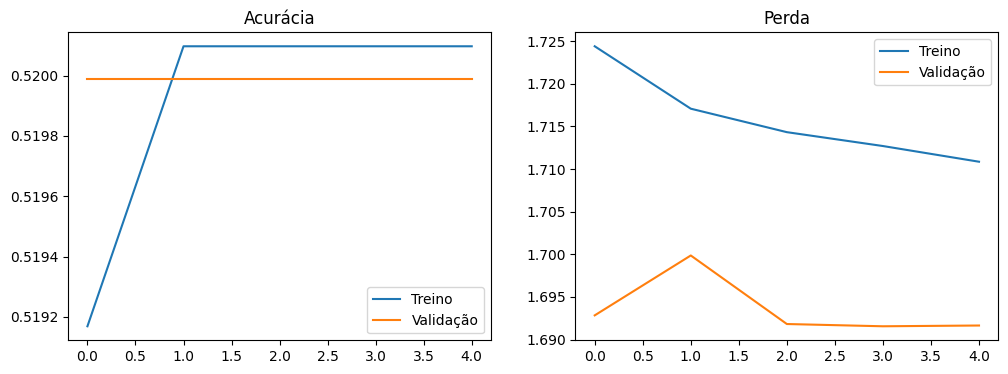

In [19]:
# Avaliação e visualização dos resultados
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Treino')
plt.plot(history.history['val_accuracy'], label='Validação')
plt.title('Acurácia')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Treino')
plt.plot(history.history['val_loss'], label='Validação')
plt.title('Perda')
plt.legend()

plt.show()